In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from Bio.PDB import PDBParser
import requests
from io import StringIO

## Run the below helper functions

### Fetching corrdinates of the protein from RCSB

In [3]:
def get_res_name_coords(structure):
    """Extract residue names and coordinates from the structure."""
    res_seq = []
    res_coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                # print(residue)
                if 'CA' in residue:  # Check if CA atom exists (for amino acids)
                    ca = residue['CA']
                    res_seq.append(residue.get_resname())
                    res_coords.append(ca.get_coord().tolist())
                    # print(f"{residue.get_resname()}: {ca.get_coord()}")

    return res_seq, res_coords

### Finding N nearest neighbours

In [4]:
def N_nn(res_coords, N):
    """    
    Find the N nearest neighbours for each residue in the given coordinates.
    Args:
        res_coords (list): List of residue coordinates.
        N (int): Number of nearest neighbours to find.
    Returns:
        dict: A dictionary where keys are residue indices and values are dictionaries of nearest neighbours and their distances.
    """
    res_nn_dict = dict() # stores the N nearest neighbours and their pairwise distances for all residues
    for i, tgt in enumerate(res_coords):
        res_nn_dict[i] = dict() # stores the resid index and its pairwise distance with the target residue i
        for j, neigh in enumerate(res_coords):
            if i == j:  # Skip the same residue
                continue
            
            dist = np.linalg.norm(np.array(tgt) - np.array(neigh))
            if len(res_nn_dict[i]) < N:
                res_nn_dict[i][j] = dist
            else:
                if dist < max(res_nn_dict[i].values()):
                    # Remove the farthest neighbour
                    farthest_key = max(res_nn_dict[i], key=res_nn_dict[i].get) # Returns the key with the maximum value
                    del res_nn_dict[i][farthest_key]
                    # Add the new neighbour
                    res_nn_dict[i][j] = dist

    return res_nn_dict

### Finding all the residues within a given distance threshold

In [5]:
def nn_within_threshold(res_coords, threshold):
    """
    Finds all residues within a given distance threshold from each residue.
    Args:
        res_coords (list): List of residue coordinates.
        threshold (float): Distance threshold for neighbors.
    Returns:
        dict: A dictionary where keys are residue indices and values are dictionaries of neighboring residues and their distances.
    """
    res_nn_dict = dict() # stores the N nearest neighbours and their pairwise distances for all residues
    for i, tgt in enumerate(res_coords):
        res_nn_dict[i] = dict() # stores the resid index and its pairwise distance with the target residue i
        for j, neigh in enumerate(res_coords):
            if i == j:  # Skip the same residue
                continue
            
            dist = np.linalg.norm(np.array(tgt) - np.array(neigh))
            if dist <= threshold:
                res_nn_dict[i][j] = dist
            else:
                continue

    return res_nn_dict

In [6]:
def draw_PPI_network(pdb_id, res_seq, res_nn_dict):
    """    Draws the PPI network using NetworkX and Matplotlib.
    Args:
        pdb_id (str): PDB ID of the protein.
        res_seq (list): List of residue names.
        res_nn_dict (dict): Dictionary of nearest neighbours and their distances.
    """
    G = nx.Graph()
    for i, res in enumerate(res_seq):
        G.add_node(i, res=res)  # Add residue as a node with its index

    pos = nx.spring_layout(G)

    for i in res_nn_dict.keys():
        for j in res_nn_dict[i].keys():
            G.add_edge(i,j)

    plt.figure(figsize=(12, 8))
    plt.title(f"PPI Network for {pdb_id} with {len(G.nodes())} residues and {len(G.edges())} edges", fontweight='bold', fontsize=16)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_weight='bold')

    return G

## Run this parent function which calls all the helper functions to generate the PPI network

In [7]:
def generate_PPI(pdb_id, N=None, threshold=None):
    # Fetch PDB file as a string from RCSB
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)

    if response.status_code == 200:
        pdb_data = response.text

        # Load the PDB data using Biopython's PDBParser
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure(pdb_id, StringIO(pdb_data))
    
        # Now `structure` is ready for use in memory
        print(structure)
    else:
        print(f"Failed to fetch PDB file for {pdb_id}")

    # Extracts residue names and coordinates
    res_name, res_coords = get_res_name_coords(structure)

    # Calculating nearest neighbours
    if N is not None and threshold is None:
    # Finding N nearest neighbours
        res_nn_dict = N_nn(res_coords, N)
    
    elif threshold is not None and N is None:
    # Finding all the residues within a given distance threshold
        res_nn_dict = nn_within_threshold(res_coords, threshold)
    else:
    # Finding all the residues within a given distance threshold
        print("Please provide either N or threshold to calculate the nearest neighbours.")

    # Draw the PPI network
    G = draw_PPI_network(pdb_id, res_name, res_nn_dict)
    return G

### Enter your PDB id and the method to calculate nearest neighbours

<Structure id=3vub>


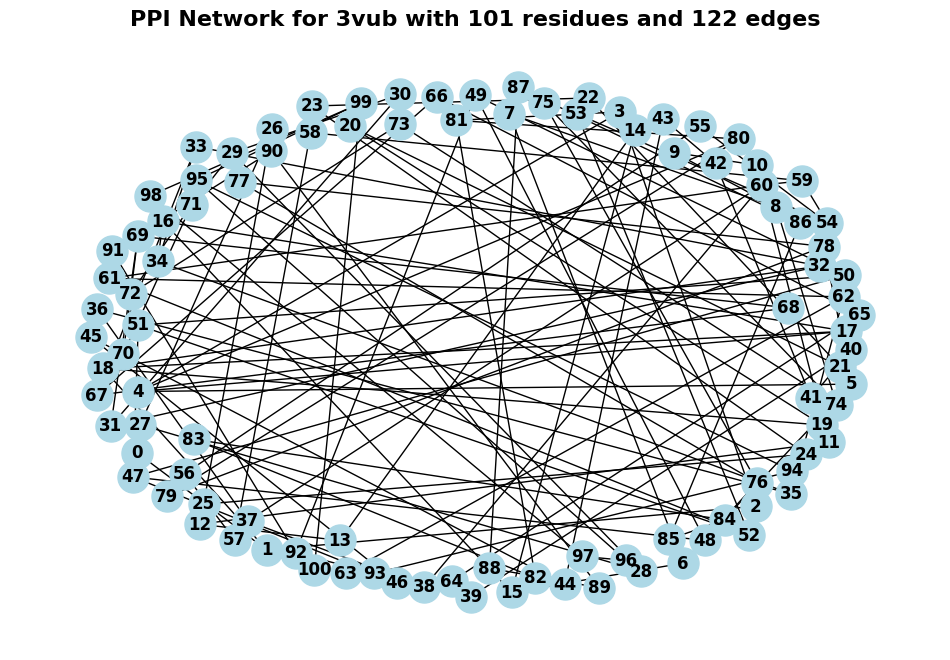

In [8]:
graph = generate_PPI('3vub', threshold=5)

In [24]:
import plotly.graph_objects as go

In [ ]:
edge_x = []
edge_y = []

for u, v in graph.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in graph.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=[str(n) for n in G.nodes()],
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=15,
        color=[],
        colorbar=dict(thickness=15, title='Node Degree')
    )
)

node_trace.marker.color = [len(list(G.neighbors(n))) for n in G.nodes()]

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Interactive PPI Network',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                ))

fig.show()

NameError: name 'G' is not defined